<a href="https://colab.research.google.com/github/adityaprasad2005/ES335-assignment_2/blob/main/task2_image_reconstruction_siren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing all Libraries**

In [1]:
import torch                 # A fundamental library for nn and deeplearning architecture implementation
import torchvision           # An extension of pytorch used for vision tasks and also has pre-loaded datasets like mnist and also have pre-trained models like resnet, alexnet and VGG which can be furthur trained for our specific tasks
import torchvision.transforms as transforms   # used for flipping/cropping images
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec     # While the basic plt.subplot function lets you create grids of subplots, gridspec provides more control over the size and position of these subplots.

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F  #torch.nn.functional provides a collection of functions that are commonly used in building and training neural networks like F.relu, F.tanh, F.sigmoid, F.mse_loss, F.cross_entropy

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2025-02-04 11:00:57--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 99.84.203.93, 99.84.203.80, 99.84.203.76, ...
Connecting to segment-anything.com (segment-anything.com)|99.84.203.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  1.14MB/s    in 0.2s    

2025-02-04 11:00:58 (1.14 MB/s) - ‘dog.jpg’ saved [221810/221810]



**Importing the image and cropping it**

In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
print(img)

torch.Size([3, 1365, 2048])
tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         ...,
         [121, 121, 122,  ...,  97,  96,  96],
         [121, 121, 122,  ...,  97,  97,  96],
         [121, 121, 122,  ...,  98,  97,  97]],

        [[ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         ...,
         [103, 103, 104,  ...,  82,  81,  81],
         [103, 103, 104,  ...,  82,  82,  81],
         [103, 103, 104,  ...,  83,  82,  82]],

        [[ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         ...,
         [ 37,  37,  38,  ...,  43,  42,  42],
         [ 37,  37,  38,  ...,  43,  43,  42],
         [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8)


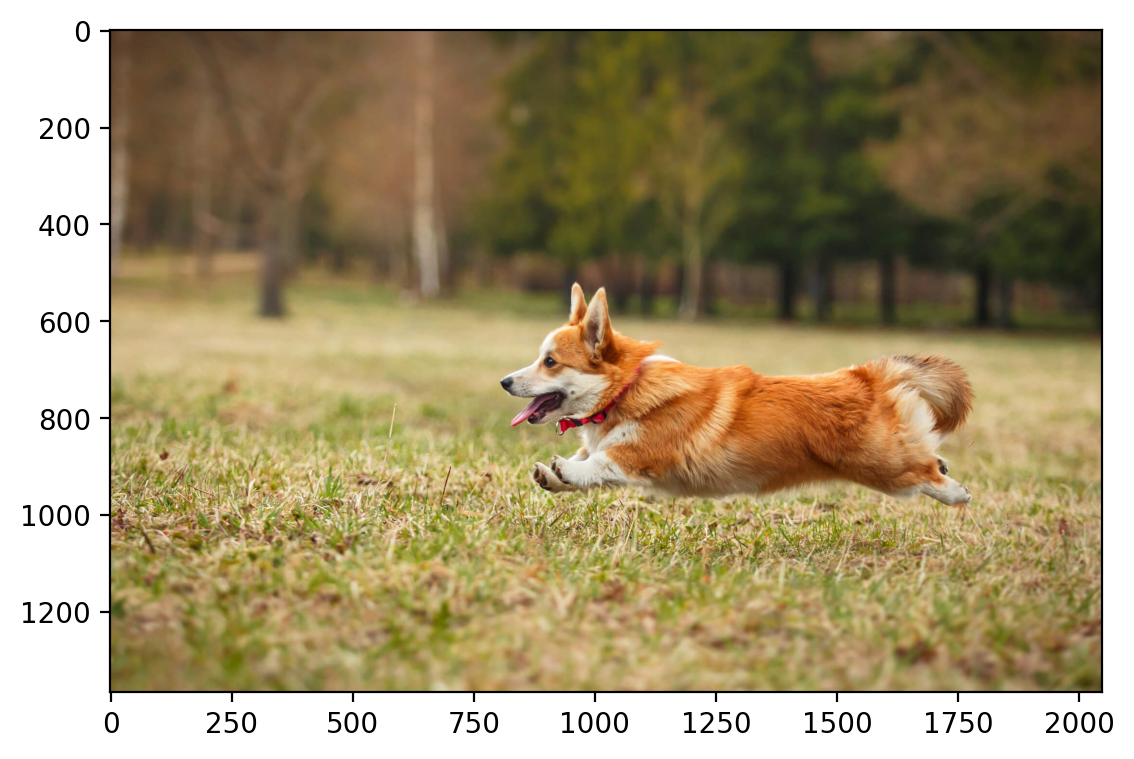

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
print(scaler_img)

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)

MinMaxScaler()
(3, 1365, 2048)


In [6]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

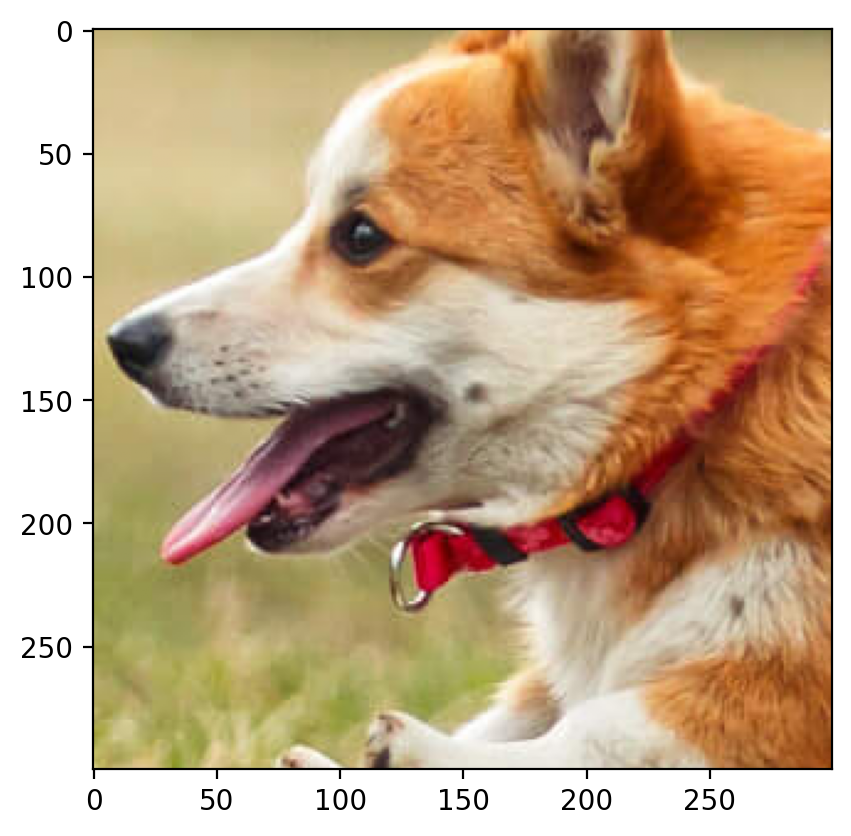

In [7]:
# This is the function being used to perform the cropping. It's from the torchvision.transforms.functional module, which provides a variety of image transformation functions.
cropped_img = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
cropped_img.shape

plt.imshow(rearrange(cropped_img, 'c h w -> h w c').cpu().numpy())

**Creating a Coordinate map**

In [8]:
# Get the dimensions of the image tensor
num_channels, height, width = cropped_img.shape
print(num_channels, height, width)

3 300 300


In [9]:
# creating a sample 2D grid of (x,y) coordinates

num_channels, height, width = 2, 3, 4

# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
# print(w_coords)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()
# print(X)
print(X.shape)

torch.Size([12, 2])


In [10]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [11]:
dog_X, dog_Y = create_coordinate_map(cropped_img)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

**Scaling down the coordinate map**

---


*This ensures lesser biases in learning the linear models*

In [12]:
# MinMaxScaler from -1 to 1
# feature_range=(-1, 1): This argument specifies that we want to scale the features to a range of -1 to 1 instead of the default 0 to 1.
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

**Function to compare the Original and Reconstructed images**

In [13]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    # net.eval(): This line sets the neural network (net) to evaluation mode. This is important when you're using the network for inference (making predictions) rather than training. In evaluation mode:
    # Dropout layers are deactivated.
    # Batch normalization layers use running statistics instead of calculating them during the forward pass.


    with torch.no_grad():   # with torch.no_grad():: This block of code disables gradient calculation. This is useful during inference because you don't need to calculate gradients when you're not updating the model's weights. It can save memory and computation time.
        outputs = net(X)
        #outputs = outputs.permute(1, 2, 0)

    # RMSE and PSNR ratios
    rmse = torch.sqrt(torch.mean((original_img - outputs.reshape(num_channels, height, width)) ** 2))
    psnr = 20 * torch.log10(1 / rmse)
    print(f"RMSE: {rmse.item():.4f}, PSNR: {psnr.item():.4f}")

    outputs = outputs.reshape(height, width, num_channels)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

**Training a Single Linear Layer MLP nnet**

In [14]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()

        self.linear = nn.Linear(in_features, out_features)   # first layer

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [15]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()

        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

In [49]:
train(net, 0.01, dog_X_scaled, dog_Y, epochs= 1000)

Epoch 0 loss: 0.490368
Epoch 100 loss: 0.043382
Epoch 200 loss: 0.036347
Epoch 300 loss: 0.036342
Epoch 400 loss: 0.036342
Epoch 500 loss: 0.036342
Epoch 600 loss: 0.036342
Epoch 700 loss: 0.036342
Epoch 800 loss: 0.036342
Epoch 900 loss: 0.036342


0.0363415889441967

RMSE: 0.2693, PSNR: 11.3960


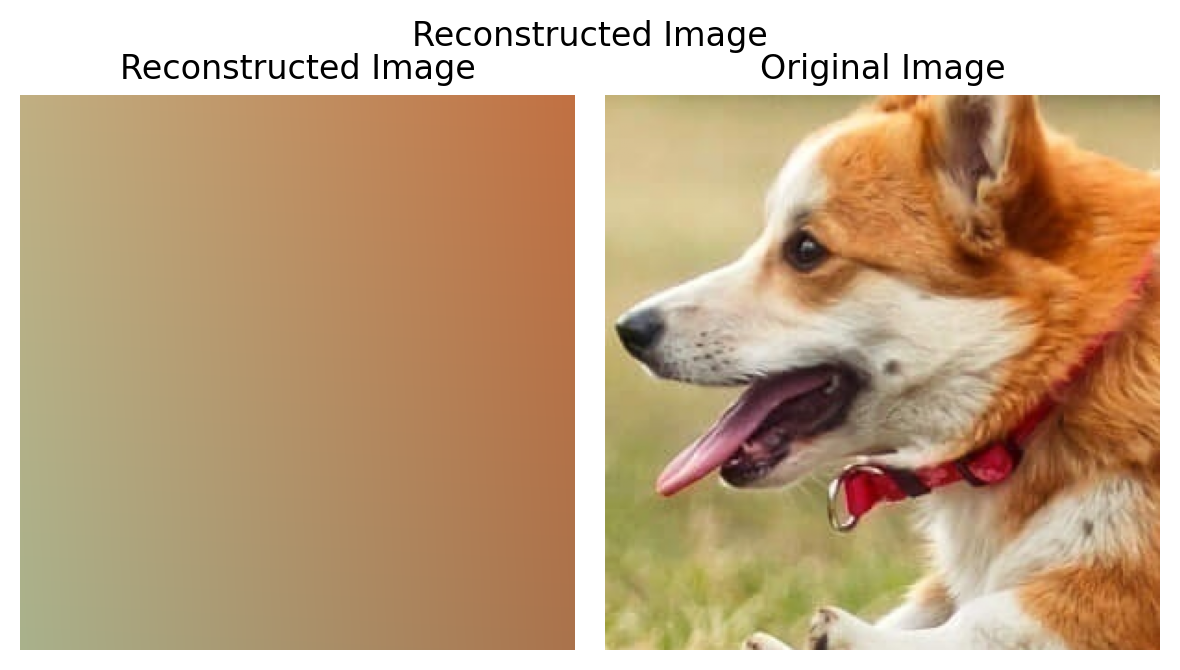

In [50]:
plot_reconstructed_and_original_image(cropped_img, net, dog_X_scaled, title="Reconstructed Image")

**Training a single-layer MLP with poylnomial input features**

In [38]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int

    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.unsqueeze(1) #X
    X2 = X2.unsqueeze(1) #Y
    X = torch.cat([X1, X2], dim=1)

    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())

    return torch.tensor(X, dtype=torch.float32).to(device)

In [40]:
dog_X_scaled_poly = poly_features(dog_X_scaled, 50)

In [41]:
dog_X_scaled_poly.dtype, dog_X_scaled_poly.shape, dog_Y.shape, dog_Y.dtype

(torch.float32,
 torch.Size([90000, 1326]),
 torch.Size([90000, 3]),
 torch.float32)

In [42]:
# Single layer mlp with 'd' I/P nodes and 3 O/P nodes
net = LinearModel(dog_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, dog_X_scaled_poly, dog_Y, 1500)

Epoch 0 loss: 0.370443
Epoch 100 loss: 0.028108
Epoch 200 loss: 0.024669
Epoch 300 loss: 0.023717
Epoch 400 loss: 0.023056
Epoch 500 loss: 0.022531
Epoch 600 loss: 0.022094
Epoch 700 loss: 0.021720
Epoch 800 loss: 0.021403
Epoch 900 loss: 0.021124
Epoch 1000 loss: 0.020891
Epoch 1100 loss: 0.020664
Epoch 1200 loss: 0.020469
Epoch 1300 loss: 0.020351
Epoch 1400 loss: 0.020131


0.019993441179394722

RMSE: 0.2962, PSNR: 10.5692


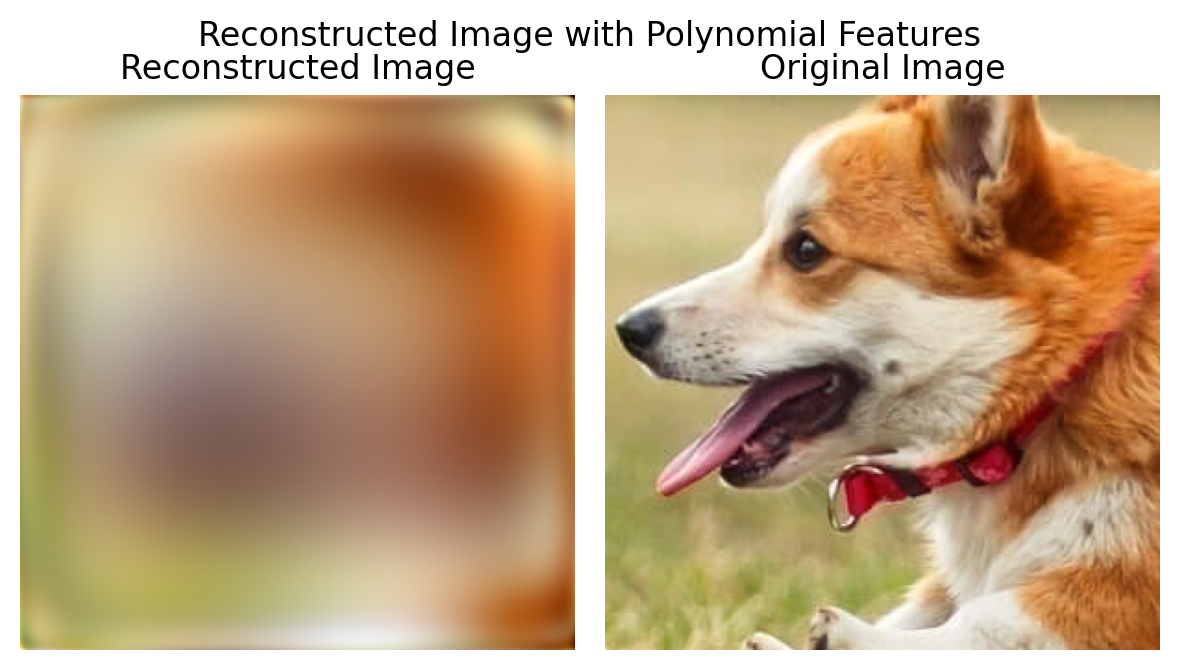

In [46]:
plot_reconstructed_and_original_image(cropped_img, net, dog_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

**Training a single layer MLP with RFF input features**

In [16]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

X_rff = create_rff_features(dog_X_scaled, 10000, 0.008)
X_rff.shape

torch.Size([90000, 10000])

In [18]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y.to(device), 2500)

Epoch 0 loss: 0.376282
Epoch 100 loss: 0.060569
Epoch 200 loss: 0.022857
Epoch 300 loss: 0.018096
Epoch 400 loss: 0.015997
Epoch 500 loss: 0.014518
Epoch 600 loss: 0.013374
Epoch 700 loss: 0.012444
Epoch 800 loss: 0.011663
Epoch 900 loss: 0.010995
Epoch 1000 loss: 0.010416
Epoch 1100 loss: 0.009910
Epoch 1200 loss: 0.009464
Epoch 1300 loss: 0.009070
Epoch 1400 loss: 0.008720
Epoch 1500 loss: 0.008408
Epoch 1600 loss: 0.008130
Epoch 1700 loss: 0.007881
Epoch 1800 loss: 0.007659
Epoch 1900 loss: 0.007458
Epoch 2000 loss: 0.007278
Epoch 2100 loss: 0.007116
Epoch 2200 loss: 0.006969
Epoch 2300 loss: 0.006836
Epoch 2400 loss: 0.006714


0.006603742949664593

RMSE: 0.3204, PSNR: 9.8866


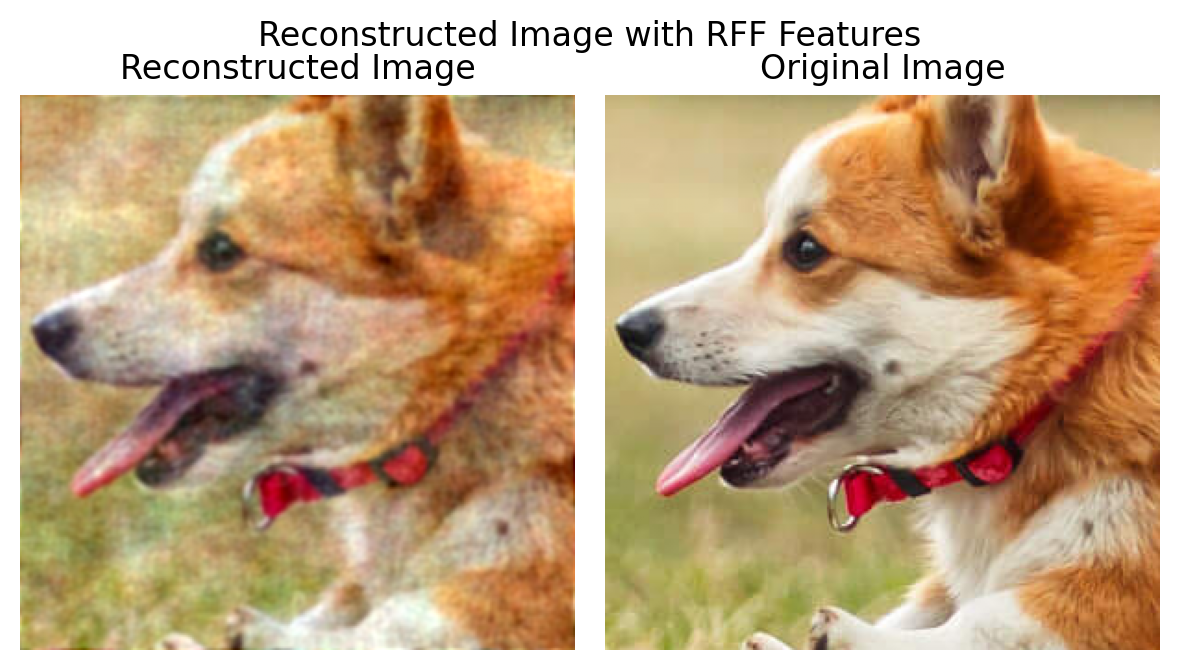

In [20]:
plot_reconstructed_and_original_image(cropped_img.to(device), net, X_rff, title="Reconstructed Image with RFF Features")